In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spacy for categorising words
import spacy
# make sure you download the below via console
# python -m spacy download en_core_web_sm

# text sentiment
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [8]:
df = pd.read_csv('DisneylandReviews.csv', encoding = 'latin-1' )

In [99]:
# average rating by branch
df_branch_rating = df.groupby('Branch')['Rating'].mean().astype(int).reset_index().rename(columns = {'Rating' : 'Average_Rating'})

# number of reviews between branch
df_branch_reviews = df.groupby('Branch')['Review_Text'].count().reset_index().rename(columns = {'Review_Text' : 'Number_of_Reviews'})

# total number of reviews
t_count = df['Review_ID'].count()
df_branch_weight = (df.groupby('Branch')['Review_Text'].count()/t_count*100).astype(int).reset_index().rename(columns = {'Review_Text' : 'Percent_of_Total'})

In [104]:
# merge findings
df1 = pd.merge(pd.merge(df_branch_reviews, df_branch_weight, on = ['Branch']), df_branch_rating, on = ['Branch'])

# plot findings
x = df1['Number_of_Reviews']
y = df1['Branch']
ap = df1['Percent_of_Total']

fig, ax = plt.subplots(figsize = (8,8))
ax.bar(y, x, label = 'Number of Reviews')
ax.legend()
plt.show()

# We can see that the majority of reviews are done in California while the least are in Paris.
# Both California and Hong Kong have a good Average Rating whereas Paris is the lowest, even though there are more reviews in Paris than in Hong Kong..
# Will this mean that our customers in Paris don't appreciate the attraction more than the other resort ?

,Branch,Number_of_Reviews,Percent_of_Total,Average_Rating
0,Disneyland_California,19406,45,4
1,Disneyland_HongKong,9620,22,4
2,Disneyland_Paris,13630,31,3


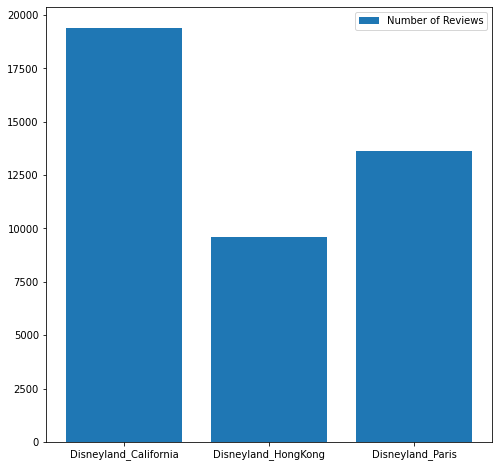

In [91]:
# convert reviews into an array of sentences
my_reviews = df['Review_Text'].squeeze()

# get a sentiment rough value using textblob
sentiment = []
for i in my_reviews:
    blob = TextBlob(i)
    sentiment.append(blob.sentiment.polarity)
    
df['sentiment'] = sentiment # add into our data frame

In [93]:
# split our reviews between high and low
low_reviews = df[df['Rating'] <=4].squeeze() 
high_reviews = df[df['Rating'] >4].squeeze()

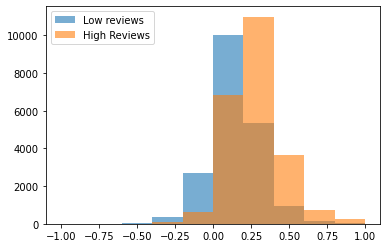

In [94]:
# compare my ratings with my sentiment in a dataframe and look for differences
x1 = low_reviews['sentiment']
x2 = high_reviews['sentiment']

fig, ax = plt.subplots()
ax.hist(x1, alpha = 0.6, label = 'Low reviews')
ax.hist(x2, alpha = 0.6, label = 'High Reviews')
ax.legend()
plt.show()

# we can see that there are high reviews with negative sentiments and low reviews with positive sentiments.
# what this means is that there are elements in the review that were good and elements that were bad.
# lets isolate the sentences to identify the good and bad values.

In [112]:
# seperate the sentences in reviews from our low review list
nlp = spacy.load("en_core_web_sm") # load spacey

sentences = [] # list my sentences in a review
for i in range(len(low_reviews['Review_Text'])):
    doc = nlp(low_reviews['Review_Text'].iloc[i])
    for sent in doc.sents:
        sentences.append(sent.text)

# sentence sentiment analysis
sentiment = []
for i in sentences:
    blob = TextBlob(i)
    sentiment.append(blob.sentiment.polarity)

In [116]:
# create dataframe with sentences, thier sentiment and the rating they scored
# we will need our columns
value = sentiment # sentiment value
review = sentences # sentence

# we will need a dataframe
df2 = pd.DataFrame(
    {'sentiment_value': value,
    'sentence' : review})

dfgb = df2[df2['sentiment_value'] == 1] # find the good in the bad
dfbb = df2[df2['sentiment_value'] == -1] # find the bad in the bad

In [123]:
# out of all our poor reviews, 10% of our clients had something positive to say.
(len(dfgb)/len(low_reviews['Rating']))*100

10.041004613018965

In [125]:
# out of all our poor reviews, 4.7% of our clients had the worst things to say.
(len(dfbb)/len(low_reviews['Rating']))*100

4.756535110199898

In [195]:
# I want to identify the nouns being used by the positve sentences and label them
# Then, I want to list our entities
nlp = spacy.load("en_core_web_sm")
important_word = []
important_label = []

for i in range(len(dfgb['sentence'])):
    doc = nlp(dfgb['sentence'].iloc[i])
    for ent in doc.ents:
        important_word.append(ent.text)
        important_label.append(ent.label_)
        
# we will do the same for our reviews that had a negative experience - i've labelled as unimportant but they should still be useful
unimportant_word = []
unimportant_label = []

for i in range(len(dfbb['sentence'])):
    doc = nlp(dfbb['sentence'].iloc[i])
    for ent in doc.ents:
        unimportant_word.append(ent.text)
        unimportant_label.append(ent.label_)

In [196]:
# making a dataframe for the table of words
important_info = pd.DataFrame({'word' : important_word, 'label': important_label})
unimportant_info = pd.DataFrame({'word' : unimportant_word, 'label': unimportant_label})
unimportant_info

,word,label
0,Disney Hollywood Hotel,FAC
1,120,MONEY
2,55,MONEY
3,45,CARDINAL
4,Dole Whip,PERSON
...,...,...
378,Disney,ORG
379,Disney,ORG
380,Disney,ORG
381,Charles De Gaulle,PERSON


In [214]:
# identify top 10 labels
important_info.groupby('label').count().sort_values('word', ascending = False).head(10)
unimportant_info.groupby('label').count().sort_values('word', ascending = False).head(10)

,word
label,
ORG,89
DATE,59
CARDINAL,57
FAC,45
TIME,36
PERSON,33
GPE,30
MONEY,12
LOC,11


In [220]:
# We can see that there is an issue.  I've looked through the ones and identified which ones to dig into.
unimportant_info[unimportant_info.label.isin(['LOC'])].head(10) # europe and carribean ranked highest.  The carribean attraction should be looked at
unimportant_info[unimportant_info.label.isin(['ORG'])].head(10) # HK Disney ranked highest.  Chances are they had a terrible experience here.

,word,label
5,HK Disney,ORG
7,HK Disney,ORG
8,The HK Disney,ORG
13,Tarzan,ORG
16,Disney,ORG
21,HKD,ORG
22,HKD,ORG
23,Beverage,ORG
27,Disney,ORG
34,HK Disney,ORG


In [223]:
# Now lets do the same thing with highest positive sentiment in our low scored reveiews.
important_info[important_info.label.isin(['LOC'])].head(10) # people loved Space Mountain!
important_info[important_info.label.isin(['GPE'])].head(10) # HK Disney ranked highest.  Odd that they ranked highest in positive and negative sentiments
important_info[important_info.label.isin(['ORG'])].head(10) # Nothing spectacular

,word,label
11,two,CARDINAL
30,3,CARDINAL
31,1,CARDINAL
40,3.70,CARDINAL
43,4.50,CARDINAL
53,over a million,CARDINAL
59,one,CARDINAL
64,10 13,CARDINAL
103,2,CARDINAL
109,one,CARDINAL
